# **There is 1 graded question for evaluation in this notebook. Do your submissions by Tuesday, 17/09/2024, 11:00 AM.**

Submission Link: https://forms.gle/zT5fvUp5eyWKtaW98

# Optimizers in PyTorch

We're going to walk through some gradient descent optimization algorithms, giving some intuition on how they work and then implementing each one in PyTorch.

Now, let's begin by importing some libraries we'll be using.

**ANKIT KUMAR
     2023H1030076P **

In [ ]:
#!pip install torchvision

**ANKIT KUMAR
     2023H1030076P **

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

We'll also set the random seed.

In [ ]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

We will be using MNIST dataset. MNIST is made up of hand drawn digits, from 0-9, represented by 28×28 pixel black-and-white images.

We'll normalize the images using a pre-computed mean and standard deviation and perform some data augmentation, namely: randomly rotating and cropping the images.

Note that we only get the training data as we only care about how well these optimizers minimize loss and not how well the architecture generalizes. In practice lower training loss doesn't necessarily imply better validation/test loss due to overfitting.

In [ ]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data',
                            train = True,
                            download = True,
                            transform = train_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16746552.46it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 531427.43it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4501425.69it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3867342.42it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



We then create the iterator for the data.


In [ ]:
batch_size = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = batch_size)

Next, we'll define our architecture: a neural network with a single hidden layer.

The `init_params` function can be called to initialize the values following the "Kaiming" (also known as "He") initialization scheme because this usually does a good job when using the ReLU activation function. The biases are initialized to zeros, which is pretty common.

ReLU = min(0,x)

Why does Kaiming/He initialization work better for ReLU activation?
___
Kaiming Initialization: $w_{l} \sim \mathcal{N}\left(0,  2/n_{l}\right)$

A gaussian distribution centered over 0 with a standard deviation of $\sqrt{2/{n}_{l}}$, biases initialized to 0.

Where $n_l$ is `fan_in` or the number of incoming connections to the neuron.

Expressed in code as: `weight = np.sqrt(2 / fan_in) * np.random.randn(*weight.shape)`

Unlike other activation functions like sigmoid, ReLU activation outputs 0 for negative input values. This can lead to gradients becoming extremely small or outright disappearing during backpropagation, especially for networks with many layers.

Kaiming initialization scales weights based on the fan-in or incoming connections to each neuron. This ensures that the average activation across layers remains close to 0.5, allowing gradients to flow more effectively and avoiding vanishing.

The scaling factor in Kaiming initialization, $\sqrt{\frac{2}{n_{l}}}$, is chosen carefully to ensure that information isn't lost or amplified excessively between layers, aiding in stable learning.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Our model uses a 256-dimensional hidden layer. Again, this is chosen pretty much arbitrarily and smaller values may work just as well.

In [ ]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

Supervised learning where each example belongs to a single class almost always uses cross-entropy loss.

In [ ]:
criterion = nn.CrossEntropyLoss()

We'll then put the `.to` method to put the model and the loss function on to our GPU, if we have one.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

Next up, we'll define some functions for training the model with our optimizers and plotting the results.

`train_epoch` performs a single epoch of training and returns a list of losses per batch.

In [ ]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""

    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

`train` initializes a model and then performs `n_epochs` of training, storing and returning the loss per batch over all the epochs.

In [ ]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs."""

    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

We have two functions for viewing our results.

`plot_loss` is used for plotting the results of a single experiment. `plot_losses` plots the results of multiple experiments, which is used to compare optimizers against each other.

In [ ]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [ ]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

Now let's implement our first optimizer!

## Optimizer 1: Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm, so it's a good place to start. We take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta J(\theta_t)$, multiplied by the "learning rate", $\eta$.

We can think of the learning rate as a parameter that controls the magnitude of the parameter update. If our learning rate is too small then our parameter updates will also be too small for us to train our model in a reasonable amount of time. Conversely, if our learning rate is too large then the size of the parameter updates will be so large that learning will become unstable! If you ever get a `NaN` value for your loss, one of the first things to try would be lowering the learning rate.

The SGD algorithm is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one set of parameters, $\theta$, we have multiple parameters: the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

We subtract because we want to descend the gradient and move towards a lower loss value. Addition would ascend the gradient, hence it's called gradient ascent.

One final thing to mention is the difference between gradient descent, stochastic gradient descent, mini-batch gradient descent and on-line gradient descent. **Gradient descent** means we calculate the gradient using every single example in our training set and then do a single parameter update. This is relatively slow as in our experiments it means only updating the parameters after seeing all 60,000 examples. The other extreme is **stochastic gradient descent** which means we update our parameters after every single example. This is usually very noisy, so a happy medium is updating the parameters after we have seen a *mini-batch* of examples,  **mini-batch gradient descent**. Lastly, **on-line gradient descent**, which usually implies our model is in production and is being constantly fed new examples on which it is using to update its parameters.

**Gradient descent** is sometimes called **batch gradient descent**, where the whole dataset counts as one giant batch, hence using sampled batch of examples is called a *mini-batch*.

In PyTorch, the optimizer is called *stochastic gradient descent* even though it can do any of the above gradient descent variants. The general rule of thumb is that nowadays when someone mentions stochastic gradient descent then they mean mini-batch gradient descent.

Moving on to the implementation. All optimizers need a way of keeping track of the parameters they're supposed to be updating `model_params` and a learning rate, `lr`. SGD in PyTorch doesn't have a default learning rate but `1e-3` is a common default learning rate value for other optimizers, so we use it here. All optimizers need a `zero_grad` function in order to remove the gradients calculated from the last update step, and a `step` function to perform a parameter update.

Note that any PyTorch method with a trailing underscore, e.g., `.sub_`, means the operation is in-place. This means our `step` function is updating each `param`, a tensor of parameters, in-place. These in-place operations are usually significantly faster non in-place operations.

In [ ]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

We can define our optimizer like so:

In [ ]:
optimizer = SGD(model.parameters())

Then we use it to train our model for five epochs and get the training loss.

In [ ]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Now let's plot it and see what it looks like.

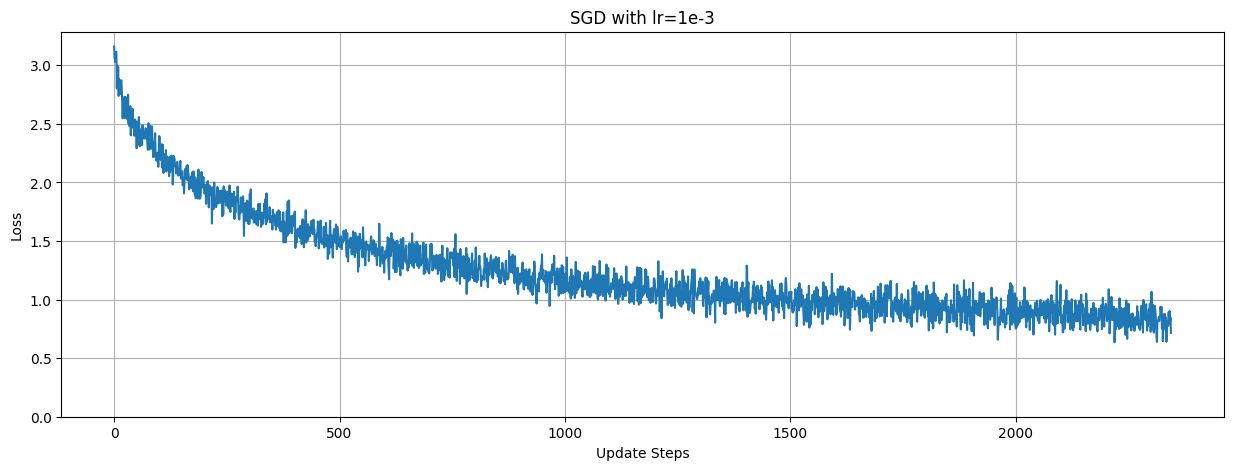

In [ ]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

Looks reasonable, the loss starts at a high value as our parameters are randomly initialized and then proceeds to decrease steadily. We can't really tell how "good" it is without comparing it against another optimizer, so let's go ahead and do that now.

## Optimizer 2: SGD with Momentum

One way to think of SGD is a ball rolling down a hill, where areas of high gradient are steep parts of the hill and areas of low gradient are very flat areas. Sometimes the global minima, the point with the lowest loss, is in the middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small update steps which makes learning slow.

We'd want to add something to our optimizer that made it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas.

That's exact what SGD with momentum does! Our parameter update is now calculated using a velocity, $v$, which depends on the current gradient multiplied by the learning rate plus the previous velocity multiplied by the momentum $\gamma$.

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

If momentum is zero then we don't care about the previous velocity at all and this algorithm becomes SGD. Commonly used momentum values are usually around 0.9.

PyTorch's optimizers are sometimes a little different from the actual algorithms. PyTorch's version of SGD with momentum moves the learning rate outside the equation for velocity:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot v_{t,i}\\
\end{align*}

If the PyTorch implementation differs then we'll implement the PyTorch version as we use it as a reference.

Note that the velocity `v` is a list of tensors corresponding to the model parameters, so we are storing the velocity of every single parameter in our model.

# Exercises

**Graded question:**

**Implement SGD with Momentum. Complete the below code.**(Areas with # sign)

**Plot the comparison curves** for given code of **SGD with momentum** against **SGD**.

In [ ]:
# class SGDMomentum:
#     def __init__(self, model_params, lr=1e-3, momentum=0.9):
#         self.model_params = #
#         self.lr = #
#         self.momentum = #
#         self.v = #

#     def zero_grad(self):
#         for param in self.model_params:
#             #

#     @torch.no_grad()
#     def step(self):
#         for param, v in zip(self.model_params, self.v):
#             #

class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)  # Convert to list to iterate over
        self.lr = lr  # Learning rate
        self.momentum = momentum  # Momentum factor
        self.v = [torch.zeros_like(param) for param in self.model_params]  # Initialize velocities as zeros

    def zero_grad(self):
        for param in self.model_params:
            if param.grad is not None:
                param.grad.zero_()  # Zero out the gradients

    @torch.no_grad()  # Ensures the gradients aren't tracked
    def step(self):
        for param, v in zip(self.model_params, self.v):
            if param.grad is not None:
                # Update the velocity term
                v.mul_(self.momentum).add_(param.grad, alpha=self.lr)
                # Update the parameters
                param.sub_(v)

In [ ]:
optimizer = SGDMomentum(model.parameters())

In [ ]:
sgdMomentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


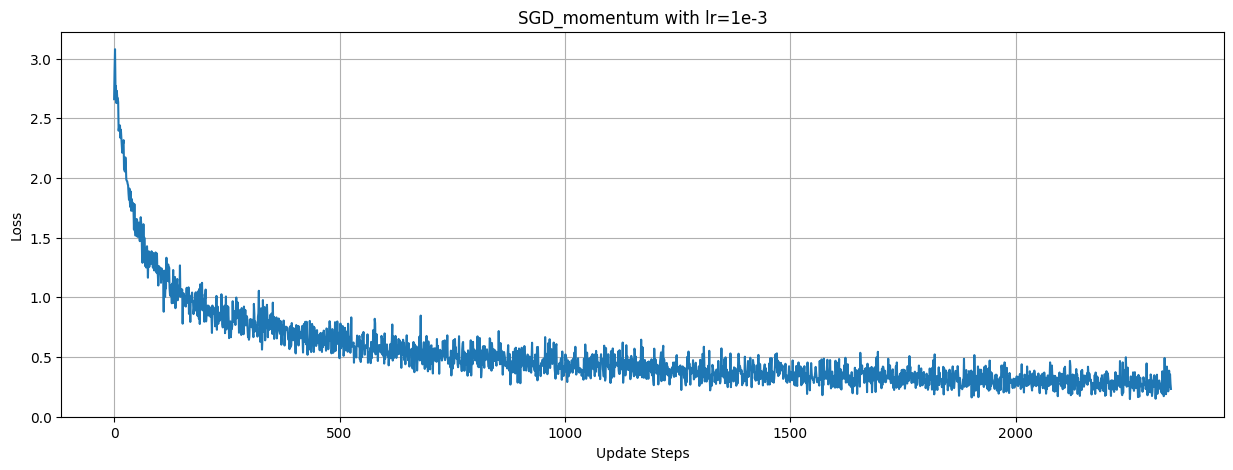

In [ ]:
plot_loss(sgdMomentum_loss, 'SGD_momentum with lr=1e-3')

In [ ]:
# # Plot the comparison
# plt.figure(figsize=(8, 6))
# plot_loss(sgdMomentum_loss, 'SGD_momentum with lr=1e-3')
# plot_loss(sgd_loss, 'SGD with lr=1e-3')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('SGD vs SGD with Momentum (lr=1e-3)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
#plot_loss(sgd_loss, 'SGD with lr=1e-3')

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(sgd_loss, sgdMomentum_loss):
    plt.figure(figsize=(8, 6))  # Set a reasonable figure size, e.g., 10 inches by 6 inches
    plt.plot(sgd_loss, label='SGD Loss')
    plt.plot(sgdMomentum_loss, label='SGD Momentum Loss')
    plt.xlabel('update steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

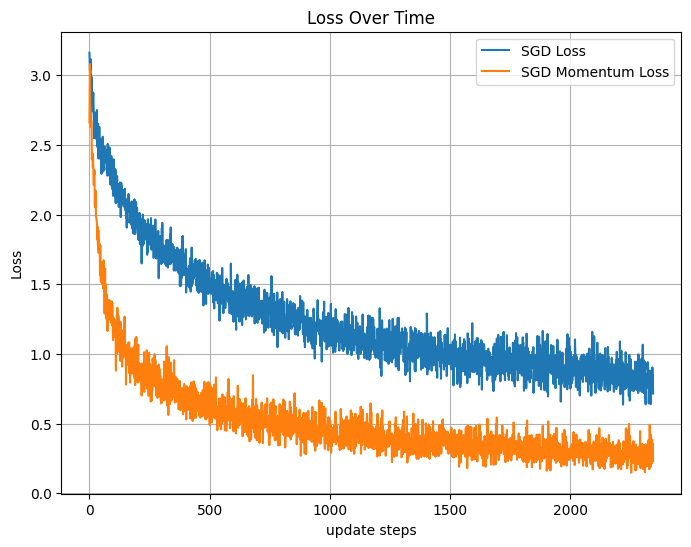

In [ ]:
plot_loss(sgd_loss, sgdMomentum_loss)

In [ ]:
#check length
print(f"Length of sgd_loss: {len(sgd_loss)}")
print(f"Length of sgdMomentum_loss: {len(sgdMomentum_loss)}")

Length of sgd_loss: 2345
Length of sgdMomentum_loss: 2345


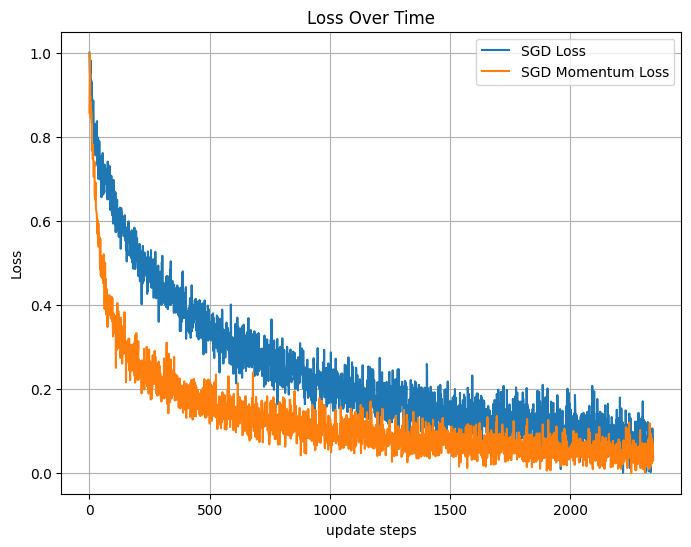

In [ ]:
import numpy as np
#normalize  for better plot
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

sgd_loss_norm = normalize(sgd_loss)
sgdMomentum_loss_norm = normalize(sgdMomentum_loss)

plot_loss(sgd_loss_norm, sgdMomentum_loss_norm)

# Optional Reading

## Optimizer 3: Adagrad (Optional)

One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training.

Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate.

This is what Adagrad does. We use $G_{t,i}$ which is the sum of the squared gradients for parameter $i$ up to, and including, time-step $t$. $G_{t,i}$ is initialized to some value, usually zero by default. As the square of the gradients of a parameter are accumulated, $G_{t,i}$ increases, and thus reduces the learning rate for parameter $i$.

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})$$

where:

$$G_{t,i} = G_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2$$

$\epsilon$ is very small number, used to avoid division by zero in the denominator. Sometimes you'll see $\epsilon$ inside the square root, and sometimes it will be outside. PyTorch leaves it outside so we will too.

We implement Adagrad below, initializing $G$ as a list of tensors called `acc_sqr_grads` and using `std` to refer to the denominator of the update step equation.

In [ ]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [ ]:
optimizer = Adagrad(model.parameters())

In [ ]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


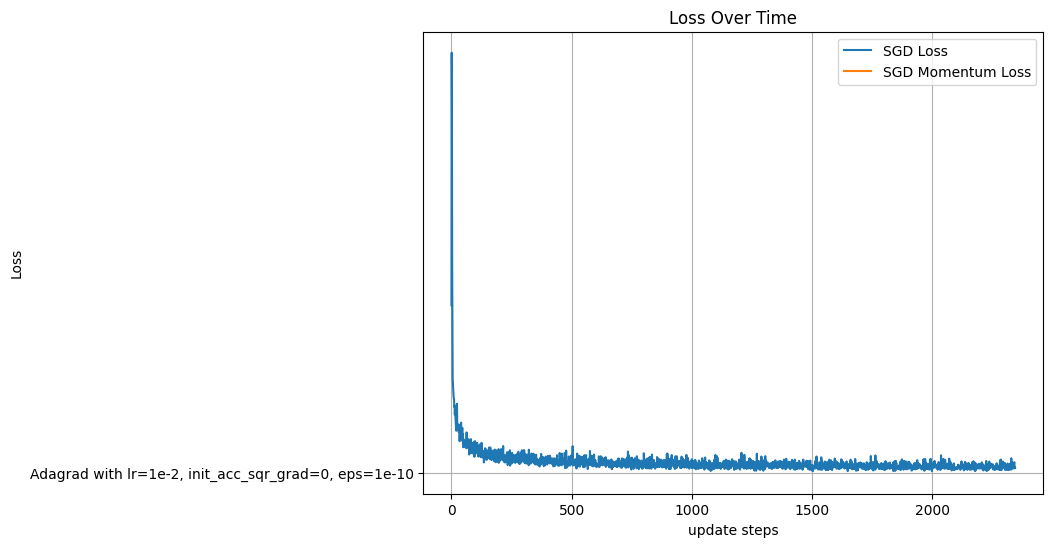

In [ ]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10')

We can see there's an initial large spike in the loss value. This is due to the initial $G$ values being very small and thus the learning rate is divided by a very small number making it very large. Very large learning rates usually lead to unstable training which give higher loss values.

Let's trim the start to get a better view what the final loss value is.

In [ ]:
#plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10', ymax=5.0)

Adagrad beats the other two pretty handily, but that initial spike in loss doesn't look very nice. Maybe if we get rid of that initial spike we can make Adagrad perform even better? Let's try some different initial values for $G$ and store them all in a `adagrad_losses` dictionary. Each key in the dictionary will be the initial $G$ value and the values of the dictionary will be a list of training loss per batch.

In [ ]:
adagrad_losses = {0: adagrad_loss}

In [ ]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=1.0)

In [ ]:
adagrad_losses[1.0] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:24<00:00, 19.13it/s]


In [ ]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.1)

In [ ]:
adagrad_losses[0.1] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:24<00:00, 19.34it/s]


In [ ]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.01)

In [ ]:
adagrad_losses[0.01] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:24<00:00, 19.41it/s]


In [ ]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.001)

In [ ]:
adagrad_losses[0.001] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


Now let's compare all of our four values for the initial $G$ value.

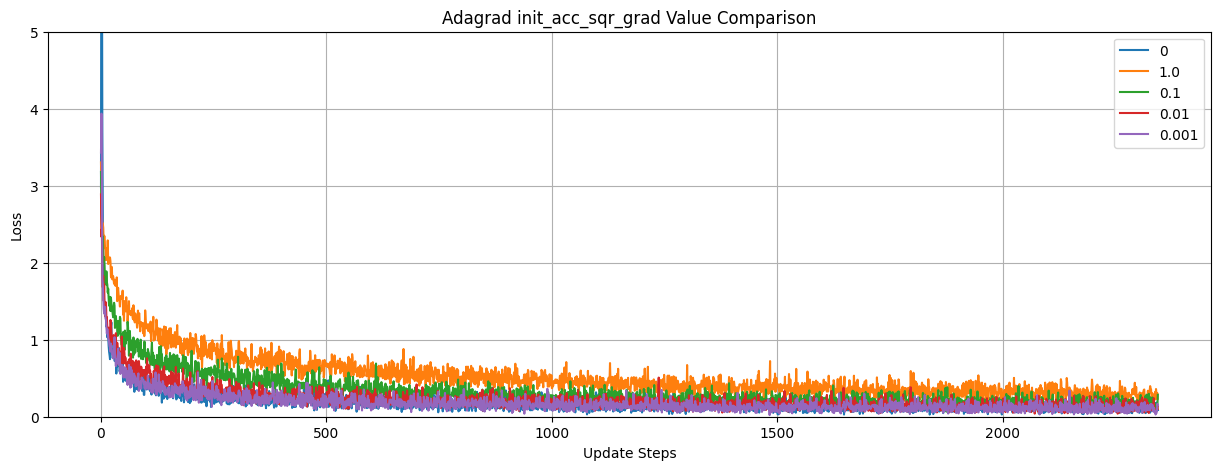

In [ ]:
labels, losses = zip(*adagrad_losses.items())

plot_losses(losses, labels, 'Adagrad init_acc_sqr_grad Value Comparison', ymax=5.0)

As we can see, performance of Adagrad increases as the initial $G$ value decreases, but decreasing $G$ also increases the initial spike in loss at the beginning of training.

Why does the performance decrease as the initial $G$ value increases? This is the major downside of Adagrad: as $G$ is monotonically increasing at each time-step it will be dividing the learning rate by a monotonically increasing number at each time-step. This causes the size of the steps taken to reduce every update step. As the results for an initial $G$ value of 1.0 show, we can see that these smaller step sizes actually increase the time taken for the model to converge, and in extreme cases will cause the step sizes to approach zero meaning the parameters will stop updating completely.

In practice, we do want the learning rate to decrease whilst training, but ideally would not want it to become zero.

## Optimizer 4: Adadelta (Optional)

All of our update step equations can be written in the form of:

$$\theta_{t+1,i} = \theta_{t,i} + \Delta \theta_{t,i}$$

where $\Delta \theta_{t,i}$ is the size of the parameter update, i.e. in SGD we had:

$$\Delta \theta_{t,i} = - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

and in Adagrad we had:

$$\Delta \theta_{t,i} = - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i}))$$

The problem of the Adagrad algorithm was that $G$ was monotonically increasing. Adadelta solves this problem by first taking the Adagrad algorithm and replacing $G_{t,i}$ with $E[g^2]_{t,i}$, an exponential moving average of the square of the gradients so far.

$$E[g^2]_{t,i} = \rho E[g^2]_{t-1,i} + (1-\rho)g^2_{t,i}$$

where $g_{t,i} = \nabla_\theta J(\theta_{t,i})$, which we've done just to simplify the notation, and $\rho$ controls how much we care about the previous gradients in the exponential moving average, $\rho=0$ means we don't care about them at all.

This means our update step equation is:

$$\Delta \theta_t = - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

Notice that the $\epsilon$ term has now moved inside the square root, which we're copying from PyTorch.

The problem with the above equation, and in fact all update equations seen so far, is the units of the update do not match the units of the parameters. The updates have units of $\frac{\delta J}{\delta \theta}$, which simplify to $\frac{1}{\text{units of }\theta}$ if we assume the cost function is unitless. However, we want our update equations to have units of $\theta$.

To solve this the Adadelta equation uses a second exponential moving average, but this one is of the parameter updates.

To get the final Adadelta equation, we take our first attempt, but replace $\eta$ with an exponential moving average of the squared parameter updates:

$$E[\Delta \theta^2]_{t-1,i} = \rho E[\Delta \theta^2]_{t-2,i} + (1-\rho)\Delta \theta^2_{t-1,i}$$

Thus, we get:

$$\Delta \theta_{t,i} = - \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

The units now "match" as we now have units of $\frac{\theta^2}{\theta} = \theta$.

This means that we do not even need to use a learning rate value, however in the PyTorch implementation they do use one (which defaults to 1.0), so they end up with:

$$\Delta \theta_{t,i} = - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

Thus:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

PyTorch also changes default `eps` value from what it was in Adagrad, from `1e-10` to `1e-6`.

In [ ]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [ ]:
optimizer = Adadelta(model.parameters())

In [ ]:
adadelta_loss = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
plot_loss(adadelta_loss, 'Adadelta with lr=1.0, rho=0.9, eps=1e-6')

We can see that we avoid the large initial spike in loss due to the numerator term (the exponential moving average of parameter updates) starting out very small.

Let's compare Adadelta to all the other algorithms so far.

In [ ]:
# Loss comparision plot here

We can see that Adagrad and Adadelta have pretty much equal performance, but Adadelta doesn't have the large initial spike in loss.

## Optimizer 5: RMSprop (optional)

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

In PyTorch, they move the $\epsilon$ term back outside of the square root. This gives us:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i}} + \epsilon} \cdot g_{t,i}$$

In the PyTorch implementation they also change the default learning rate to `1e-2`, rename `rho` to `alpha` whilst giving it a new default value of `0.99`, and also change the default `eps` to `1e-8`.

In [ ]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [ ]:
optimizer = RMSprop(model.parameters())

In [ ]:
rmsprop_loss = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8')

We run into a similar issue as we did with Adagrad, the small denominator in the initial time-steps lead to large step sizes which give huge spikes in loss values during the early stages of training.

Let's zoom in to get a better view of what's going on.

In [ ]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8', ymax=5.0)

In [ ]:
rmsprop_losses = {1e-8: rmsprop_loss}

In [ ]:
optimizer = RMSprop(model.parameters(), eps=1e-6)

In [ ]:
rmsprop_losses[1e-6] = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
optimizer = RMSprop(model.parameters(), eps=1e-4)

In [ ]:
rmsprop_losses[1e-4] = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
optimizer = RMSprop(model.parameters(), eps=1e-2)

In [ ]:
rmsprop_losses[1e-2] = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
optimizer = RMSprop(model.parameters(), eps=1)

In [ ]:
rmsprop_losses[1] = train(train_iterator, model, optimizer, criterion, device)

In [ ]:
labels, losses = zip(*rmsprop_losses.items())

plot_losses(losses, labels, 'RMSprop eps Value Comparison', ymax=5.0)

Increasing `eps` improves performance to a point, `eps=1e-2` gives the best performance, and then performance starts degrading, `eps=1` gives the worst performance.

Let's compare RMSprop against Adagrad and Adadelta.

In [ ]:
# Loss comparison plot here

It's still a bit hard to tell.

How about we smooth the loss curves with a moving average?

In [ ]:
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
smoothed_losses = [moving_average(loss) for loss in losses]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(smoothed_losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=1.0)

## Adam (Optional)
Adam has an exponential moving average of the gradients, like the momentum term that can be added to SGD, and an exponential moving average of squared gradients, like RMSprop.

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}}+\epsilon}$$

where:

\begin{align*}
    m_{t,i} &= \beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i} \\
    v_{t,i} &= \beta_2 v_{t-1,i} + (1-\beta_2)g_{t,i}^2
\end{align*}

Adam's $m_{t,i}$ is equal to $v_{t,i}$ from SGD with momentum if it had a $(1-\gamma)$ term. Adam's $v_{t,i} = E[g^2]_{t,i}$ from RMSprop, with $\rho$ replaced by $\beta_2$.

As $m$ and $v$ are initialized to zero and $\beta_1$ and $\beta_2$ are initialized close to one the $m$ and $v$ values calculated on the first few update steps are "biased" towards very small values. This is why we saw a huge loss for the first steps of Adagrad, Adadelta and RMSprop.

To solve this, Adam uses "bias corrected" values of $m$ and $v$, calculated as:

\begin{align*}
    \hat{m}_{t,i} &= \frac{m_{t,i}}{1-\beta_1^t} \\
    \hat{v}_{t,i} &= \frac{v_{t,i}}{1-\beta_2^t}
\end{align*}

This gives the final Adam equation as:

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}}+\epsilon}$$

Note that the bias corrected values on the first call to `step` are calculated with $t = 1$ and not $t = 0$.

In [ ]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in model_params]
        self.n_steps = 0

    def zero_grad(self):
        for param in self.model_params:
            if param.grad is not None:
                param.grad.zero_()

    @torch.no_grad()
    def step(self):
        self.n_steps += 1
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):

            avg_grad.mul_(self.beta_1).add_(1 - self.beta_1, param.grad)  # update avg_grad
            avg_sqr_grad.mul_(self.beta_2).addcmul_(1 - self.beta_2, param.grad, param.grad)  # update avg_sqr_grad

            avg_grad_corrected = avg_grad / (1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad / (1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)

            param.sub_(self.lr * avg_grad_corrected / std)  # update parameters

#References
https://ruder.io/optimizing-gradient-descent/

https://mlfromscratch.com/optimizers-explained/#/

https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/

https://pytorch.org/docs/stable/optim.html

https://github.com/pytorch/pytorch/tree/master/torch/optim

https://www.coursera.org/learn/machine-learning/